#Loading the Libraries and Data

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Reading the CSV File

In [83]:
filepath = '/content/drive/MyDrive/Midterm_53_group.csv'
df = pd.read_csv(filepath)
df.drop_duplicates(inplace=True)
df.ffill(inplace=True)
df.dropna(inplace=True)



In [84]:
display(df.head())


,Time,Source,No.,Destination,Protocol,Length,Info
0,0.000000,192.167.8.166,1,192.167.255.255,NBNS,92,Name query NB WPAD<00>
1,0.784682,192.167.8.166,2,192.167.255.255,NBNS,92,Name query NB WPAD<00>
2,1.169060,VMware_8a:5c:e6,3,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
3,2.167949,VMware_8a:5c:e6,4,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
4,3.170095,VMware_8a:5c:e6,5,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1


#Processed Data ready for Modelling

In [85]:
df = pd.get_dummies(df, columns=["Protocol"], drop_first=True)
df["is_query"] = df["Info"].str.contains("query", case=False).astype(int)
df.drop(columns=["Info", "Source", "Destination"], inplace=True)
scaler = MinMaxScaler()
df[["Time", "Length"]] = scaler.fit_transform(df[["Time", "Length"]])
df.head()
sample_df = df.sample(n=10000, random_state=42).copy()
display(sample_df.head())





,Time,No.,Length,Protocol_BROWSER,Protocol_DHCP,Protocol_DNS,Protocol_HTTP,Protocol_ICMP,Protocol_ICMPv6,Protocol_NBNS,Protocol_OCSP,Protocol_RARP,Protocol_SSLv2,Protocol_STUN,Protocol_TCP,Protocol_TLSv1,Protocol_TLSv1.2,Protocol_TLSv1.3,is_query
351660,0.922682,351661,0.000241,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0
147074,0.544198,147075,0.010824,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0
141496,0.520084,141497,0.029616,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0
224466,0.648344,224467,0.007303,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0
381701,0.981208,381702,0.029616,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,0


#Isolation-based Anomaly Detection

In [86]:
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
features = sample_df.columns.difference(['No.', 'anomaly', 'label', 'predicted'])
sample_df['anomaly'] = model.fit_predict(sample_df[features])
sample_df['label'] = np.where(sample_df['anomaly'] == -1, 1, 0)
sample_df['predicted'] = sample_df['label']
display(sample_df.head())

,Time,No.,Length,Protocol_BROWSER,Protocol_DHCP,Protocol_DNS,Protocol_HTTP,Protocol_ICMP,Protocol_ICMPv6,Protocol_NBNS,...,Protocol_SSLv2,Protocol_STUN,Protocol_TCP,Protocol_TLSv1,Protocol_TLSv1.2,Protocol_TLSv1.3,is_query,anomaly,label,predicted
351660,0.922682,351661,0.000241,False,False,False,False,False,False,False,...,False,False,True,False,False,False,0,1,0,0
147074,0.544198,147075,0.010824,False,False,False,False,False,False,False,...,False,False,False,False,True,False,0,-1,1,1
141496,0.520084,141497,0.029616,False,False,False,False,False,False,False,...,False,False,True,False,False,False,0,1,0,0
224466,0.648344,224467,0.007303,False,False,False,False,False,False,False,...,False,False,False,False,False,True,0,1,0,0
381701,0.981208,381702,0.029616,False,False,False,False,False,False,False,...,False,False,True,False,False,False,0,1,0,0


#Distribution of Normalised Packet length

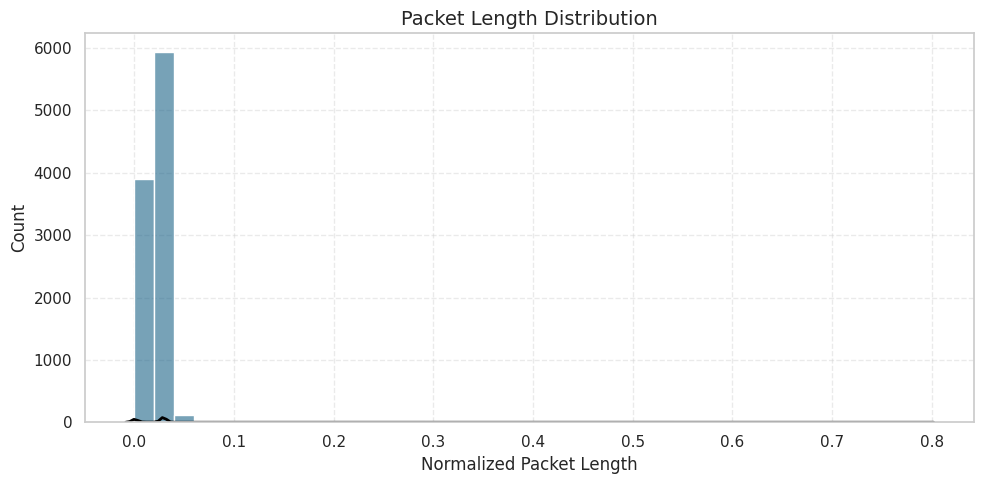

In [87]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(sample_df['Length'], bins=40, kde=False, color=sns.color_palette("crest")[4], alpha=0.6)
sns.kdeplot(sample_df['Length'], color="black", linewidth=2)
plt.title("Packet Length Distribution", fontsize=14)
plt.xlabel("Normalized Packet Length")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



#Packet Length Distribution by Anomaly Class

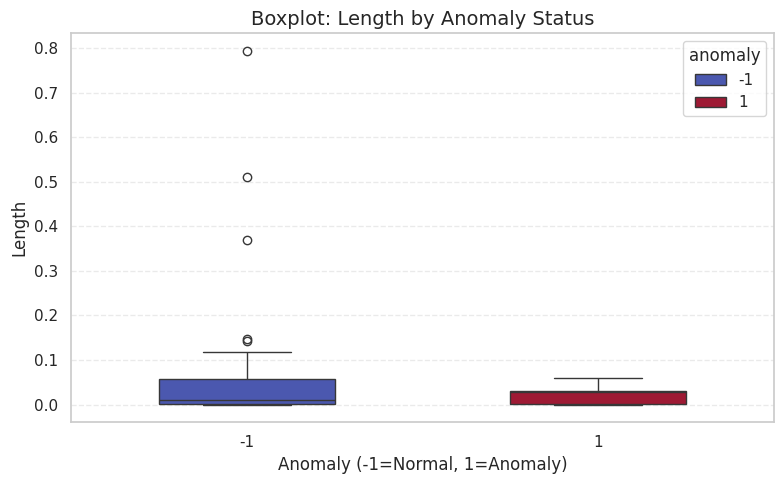

In [88]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='anomaly', y='Length', data=sample_df, hue="anomaly",palette="coolwarm", width=0.5)
plt.title("Boxplot: Length by Anomaly Status", fontsize=14)
plt.xlabel("Anomaly (-1=Normal, 1=Anomaly)")
plt.ylabel("Length")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#Correlation Heatmap

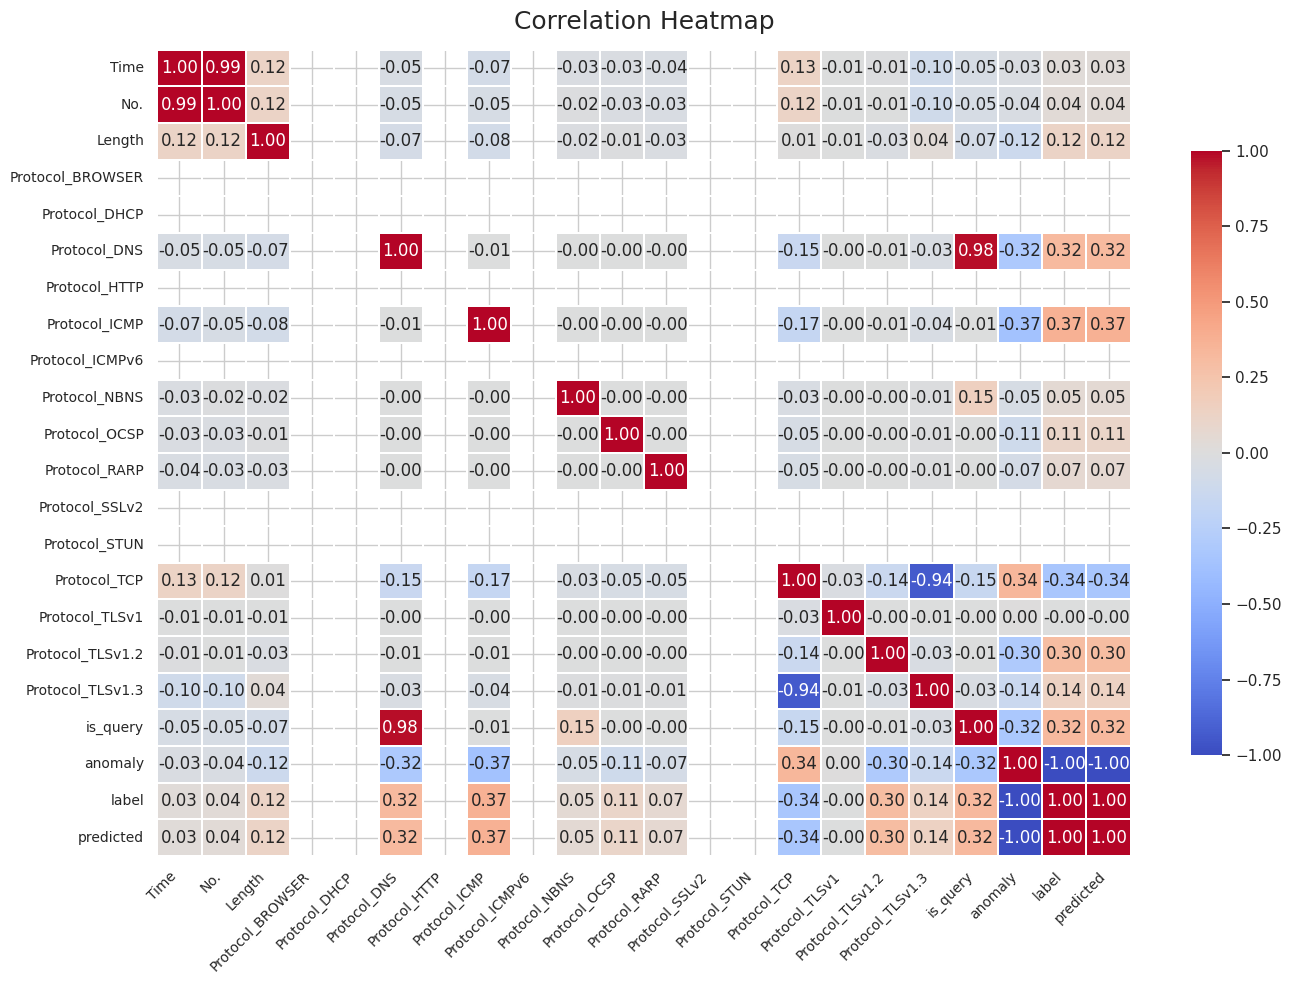

In [89]:
corr_matrix = sample_df.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar_kws={"shrink": 0.75},
    square=False
)
plt.title("Correlation Heatmap", fontsize=18, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()



#Confusion matrix for isolation forest

<Figure size 600x400 with 0 Axes>

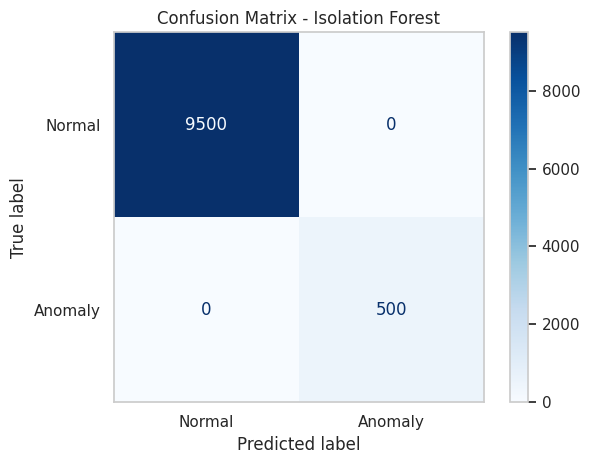

In [90]:
cm_iso = confusion_matrix(sample_df['label'], sample_df['predicted'])
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_iso, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Isolation Forest")
plt.grid(False)
plt.tight_layout()
plt.show()


#Anomaly Detection using Support Vector Machine

In [91]:
protocol_cols = [col for col in sample_df.columns if col.startswith('Protocol_')]
X = sample_df[['Time', 'Length', 'is_query'] + protocol_cols]
y = sample_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1890
           1       0.97      0.34      0.50       110

    accuracy                           0.96      2000
   macro avg       0.97      0.67      0.74      2000
weighted avg       0.96      0.96      0.95      2000



#SVM Model – Confusion Matrix Analysis



<Figure size 600x400 with 0 Axes>

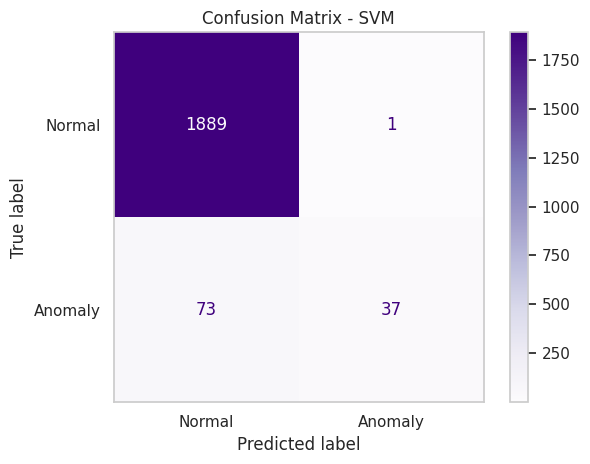

In [92]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - SVM")
plt.grid(False)
plt.tight_layout()
plt.show()



#3D PCA Anomaly Detection

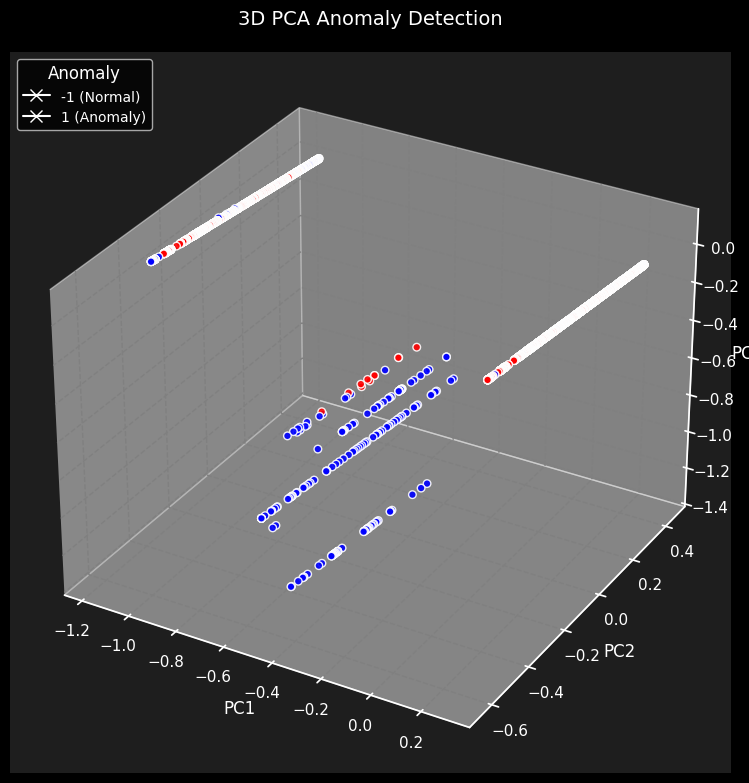

In [93]:
protocol_cols = [col for col in sample_df.columns if col.startswith('Protocol_')]
pca_features = ['Time', 'Length', 'is_query'] + protocol_cols
pca_3d_data = PCA(n_components=3).fit_transform(sample_df[pca_features])

plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d", facecolor="#1e1e1e")

colors = sample_df['anomaly'].map({-1: 'blue', 1: 'red'})
scatter = ax.scatter(
    pca_3d_data[:, 0],
    pca_3d_data[:, 1],
    pca_3d_data[:, 2],
    c=colors,
    s=30,
    alpha=0.9,
    edgecolor='white'
)

ax.set_title("3D PCA Anomaly Detection", color="white", fontsize=14, pad=20)
ax.set_xlabel("PC1", color="white")
ax.set_ylabel("PC2", color="white")
ax.set_zlabel("PC3", color="white")
ax.xaxis._axinfo["grid"].update(color="gray", linestyle="--")
ax.yaxis._axinfo["grid"].update(color="gray", linestyle="--")
ax.zaxis._axinfo["grid"].update(color="gray", linestyle="--")
ax.tick_params(colors="white")

legend_elements = [
    Line2D([0], [0], marker='x', color='w', label='-1 (Normal)', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='x', color='w', label='1 (Anomaly)', markerfacecolor='red', markersize=8)
]
ax.legend(handles=legend_elements, title="Anomaly", loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()